In [1]:
import torch

In [10]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

cpu


In [3]:
import torch.nn as nn #딥러닝 네트워크의 기본 구성요소
import torch.nn.functional as F # 딥러닝에 자주 쓰는 함수를 F로 불러오겠다
import torch.optim as optim # 가중치 추정에 필요한 최적화 알고리즘을 포함한 모듈을 optim으로 지정
from torchvision import datasets, transforms #torchvision에서 데이터셋과 transform을 가져온다

from matplotlib import pyplot as plt
%matplotlib inline

## [HyperParameter 지정]

In [4]:
batch_size = 50
epoch_num = 15
learning_rate = 0.0001

batch_size : 모델 가중치를 한 번 업데이트 시킬 때 사용되는 샘플 단위 수

In [5]:
train_data = datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
test_data = datasets.MNIST(root = './data', train = False, transform = transforms.ToTensor())
# transform : MNIST 저장과 동시에 전처리를 할 수 있는 옵션. 이미지를 텐서로 변형하는 전처리여서 ToTensor()를 써준다.

print('number of traning data: ', len(train_data))
print('number of test data: ', len(test_data))

36.6%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

84.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



10.6%

102.8%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



112.7%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

number of traning data:  60000
number of test data:  10000



/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-jhk0fkj8/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## [MNIST 데이터 확인하기]

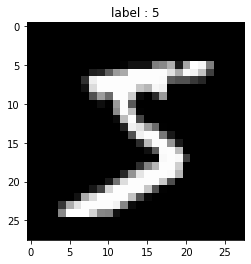

In [6]:
image, label = train_data[0]     # image 와 label 을 받아온다.

# MNIST는 단일 채널로 [1,28,28] 3차원 텐서이다. 3차원 텐서를 2차원으로 줄이기 위해 image.squeeze()를 사용한다.
plt.imshow(image.squeeze().numpy(), cmap = 'gray') #squeeze() : 크기가 1인 차원을 없애는 함수로 2차원 [28,28]로  만든다.
plt.title('label : %s' % label)
plt.show()


## [미니 배치 구성하기]

In [8]:
# DataLoader는 손쉽게 배치를 구성하며 학습과정을 반복 시행 할때 마다 미니배치를 불러오는 유용한 함수
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                          batch_size = batch_size,
                                          shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                          batch_size = batch_size,
                                          shuffle = True)


first_batch = train_loader.__iter__().__next__()
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '',
                                     len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)),
                                    len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]',
                                    str(type(first_batch[0])),
                                    first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]',
                                    str(type(first_batch[1])),
                                    first_batch[1].shape))



name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


해석을 해보면 일단 배치 구성한거다.  
size = 1200 인것은 60000장의 사진 중 50개의 샘플로 돌리기 때문에 1200의 배치가 존재하는 것이다.  
first_batch는 2개의 리스트를 갖고 있고   
[0] 은 [50,1,28,28] 로 50개의 데이터를 가진 [1,28,28] 이라는 3차원을 뜻한다  
[1] 은 50크기의 벡터인데. 바로 레이블이다. 답  

## [CNN 구조 설계하기]

In [18]:
class CNN(nn.Module):
    def __init__(self): #모델에 사용되는 가중치를 정의
        super(CNN,self).__init__() #super()를 통해 nn.Module 클래스의 속성을 상속 받고 초기화
        self.conv1 = nn.Conv2d(1,32,3,1)   #in_channel / out_channel / kernel_size / stride
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)   # 0.25 확률의 드랍아웃을 지정
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216,128)   # 9264 -> 128 -> 10
        self.fc2 = nn.Linear(128,10)
    
    def forward(self,x) :  # 입력이미지와 정의한 가중치를 이용해 feed forward 계산
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)     # (2x2 크기의 필터로 맥스 풀링 한다. 이건 가중치 할 필요가 없어서 위에서 정의 안했다)
        x = self.dropout1(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1) #softmax 말고 log_softmax()를 쓰면 연산속도를 올릴 수 있다.
        return output
        

In [19]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()    # 손실함수로 크로스엔트로피

In [20]:
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


# [모델 학습]

In [21]:
model.train()
i = 0
for epoch in range(epoch_num):
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target) # 계산값과 결과값에 대해 손실을 구해보자
        loss.backward()
        optimizer.step()  # 역전파로 계산해서 모델 가중치 업데이트
        if i % 1000 == 0 :
            print('Train Step : {}\tLoss: {:.3f}'. format(i, loss.item()))
        i += 1
        

Train Step : 0	Loss: 2.307
Train Step : 1000	Loss: 0.381
Train Step : 2000	Loss: 0.120
Train Step : 3000	Loss: 0.072
Train Step : 4000	Loss: 0.215
Train Step : 5000	Loss: 0.069
Train Step : 6000	Loss: 0.087
Train Step : 7000	Loss: 0.032
Train Step : 8000	Loss: 0.025
Train Step : 9000	Loss: 0.168
Train Step : 10000	Loss: 0.077
Train Step : 11000	Loss: 0.013
Train Step : 12000	Loss: 0.042
Train Step : 13000	Loss: 0.099
Train Step : 14000	Loss: 0.141
Train Step : 15000	Loss: 0.242
Train Step : 16000	Loss: 0.124
Train Step : 17000	Loss: 0.005


In [22]:
model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()
    
print('Test set: Accuracy : {:.2f}%'.format(100 * correct / len(test_loader.dataset)))


Test set: Accuracy : 99.09%
